# UNICEF Ghana: Handwashing with Ananse

Taking a look at time distributions of the video data

[Project Homepage](https://www.unicef.org/ghana/communication_10253.html)

[GitHub Repository](https://github.com/austinmw/ec520_ghana_handwashing)

[nbviewer](http://nbviewer.jupyter.org/github/austinmw/ec520_ghana_handwashing/blob/master/Timestamp%20Summary%20Statistics.ipynb)


** Tested for Mac, probably works with other Unix-based systems as well**

First I performed some very basic cleaning of the directories:
- Tried to standardize the spacing in file names
- Fixed outlier errors in naming conventions for some entries
- Added some empty directories where missing (Video 2) to make directory path error checking more straight forward

## 1: Import Libraries and Data

In [119]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
import os.path, time
import sys
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [135]:
# Toggle 1st/2nd hard drive
hd2 = False
if not hd2:
    hdpath = '/Volumes/Seagate/hd1/'
else:
    hdpath = '/Volumes/Seagate/hd2/' 
    
# list schools
schools = [f for f in os.listdir(hdpath) if f[0]!='.']
numSchools = len(schools)
print("School Names:",*schools, sep='\n')

School Names:
Agona Nkran Islamic
Akakom DA Primary
Akropong Presby Primary
Akwaboso Methodist Primary
Ampampatia
Asafo Presby Primary
Asamama Presby Primary
Awutu AME Zion
Ayinam Presby Primary
Gyesikrom AEDA Primary
Itifaqiya Islamic Primary
Kwabeng Anglican Primary
Mankrong Methodist Primary
Ninta Methodist
Nsabaa AME Zion
Nsabaa Methodist
Nuriya DA Primary Bawijiase
Presby Primary Bawijiase
Rev. Erickson
St. Killian Catholic Primary


## 2: Extracting the Timestamps

According to stackoverflow, retrieving file creation dates turns out to be platform-dependent.   
Testing this with Mac, although it may work with other Unix-based systems.  

In [136]:
# List of all video file paths in each school's Video/Video 1 and Video/Video 2 folders

if not hd2:
    vidPaths = [hdpath+s+'/Baseline/Video/Video 1/' for s in schools] 
    vidPaths += [hdpath+s+'/Baseline/Video/Video 2/' for s in schools]
else:
    vidPaths = [hdpath+s+'/Video 1/' for s in schools]
    vidPaths += [hdpath+s+'/Video 2/' for s in schools]
    

# convert school names to proper linux directory paths (might need later)
# escapedTopVidDirs = [hdpath+s.replace(' ', r'\ ')+'/Baseline/Video/' for s in schools]
# escaped list of paths for 'Video 1' and 'Video 2' (also may need later)
# escapedBothVidDirs = [e+'Video\\ 1/' for e in escapedTopVidDirs] + [e+'Video\\ 2/' for e in escapedTopVidDirs]

# Create large list of full file paths for each video in each school's Video 1 and Video 2 directories
vidFullPaths = [f+v for f in vidPaths for v in os.listdir(f) if v[0]!='.']
vidNum = len(vidFullPaths)
print("Number of total videos in all 'Video 1' and 'Video 2' directories: ", vidNum)

# list(each school) of lists(each vid path) for each 'Video 1' and 'Video 2' dir
v1FullPaths = [[s+v for v in os.listdir(s) if v[0]!='.'] for s in vidPaths[:int(len(vidPaths)/2)]]
v2FullPaths = [[s+v for v in os.listdir(s) if v[0]!='.'] for s in vidPaths[int(len(vidPaths)/2):]]
# aggregated above 
bothFullPaths = [v1FullPaths[i]+v2FullPaths[i] for i in range(len(v1FullPaths))] # 16730 total (hd1)

Number of total videos in all 'Video 1' and 'Video 2' directories:  16730


In [131]:
# list of lists with creation times for all videos in all 'Video 1' and 'Video 2' directories
timestamps = [time.ctime(os.path.getmtime(f)).replace('  ', ' ').split(' ') for f in vidFullPaths]

# list of lists of lists: sTimestamps[school][timestamp][section of timestamp]
sTimestamps = [[time.ctime(os.path.getmtime(v)).replace('  ', ' ').split(' ') for v in school] for school in bothFullPaths] 

# example of first 10 videos and corresponding timestamps
print("Example of full file paths and creation dates for the first five videos:\n")
for i in range(3):
    print('path:\t    ' + vidFullPaths[i],'\ntimestamp: ',timestamps[i],'\n')

Example of full file paths and creation dates for the first five videos:

path:	    /Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/VID0004.AVI 
timestamp:  ['Tue', 'Feb', '21', '14:15:34', '2017'] 

path:	    /Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/VID0005.AVI 
timestamp:  ['Tue', 'Feb', '21', '14:20:02', '2017'] 

path:	    /Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/VID0006.AVI 
timestamp:  ['Tue', 'Feb', '21', '14:20:40', '2017'] 



# 2.5: backup data

Backing up all HD1 paths/mtimes/filenames to .csv and .pkl files 

Can do statistics on this dataframe in new notebook rather than requiring HD   
(all code in this notebook still requires the HD, I wrote it before I did this backup step)

In [134]:
# Put all file info in data frame
hdFiles = pd.DataFrame([f.split('/') for f in vidFullPaths])

# check hd since they have different paths
if not hd2:
    hdFiles = hdFiles[[3,4,7,8]]
else:
    hdFiles = hdFiles[[3,4,5,6]]
    
hdFiles.columns = ['hard drive','school','video folder', 'file name']
hdFiles.head()
timestamps = pd.DataFrame([time.ctime(os.path.getmtime(f)).replace('  ', ' ').split(' ') for f in vidFullPaths], 
                          columns=['day','month','date','time','year'])
hdDataframe = hdFiles.join(timestamps)

# time to float, e.g. 10:06:30 -> 10.1050
def timetofloat(s):
    t = s.split(':')
    return float(t[0]+'.'+str(int(float(t[1])*100/60))+str(int(float(t[2])*100/60)))

# add float time column (easier for graphing)
hdDataframe['floatTime'] = hdDataframe['time'].apply(timetofloat)

# add file paths column
hdDataframe['full path'] = vidFullPaths

# check size
print(hdDataframe.shape)

# save hd1 or hd2
if not hd2:
    # save hd1 dataframe as .pkl file
    hdDataframe.to_pickle('hd1Pickle')
    # save hd1 dataframe as .csv file
    hdDataframe.to_csv('hd1CSV')
else:
    # save hd1 dataframe as .pkl file
    hdDataframe.to_pickle('hd2Pickle')
    # save hd1 dataframe as .csv file
    hdDataframe.to_csv('hd2CSV')

# see how it looks (wont work if hd2 selected)
hdDataframe.head()

(6563, 11)


,hard drive,school,video folder,file name,day,month,date,time,year,floatTime,full path
0,hd2,Nsabaa AME Zion,Video 1,VID0004.AVI,Tue,Feb,21,14:15:34,2017,14.2556,/Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/V...
1,hd2,Nsabaa AME Zion,Video 1,VID0005.AVI,Tue,Feb,21,14:20:02,2017,14.3330,/Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/V...
2,hd2,Nsabaa AME Zion,Video 1,VID0006.AVI,Tue,Feb,21,14:20:40,2017,14.3366,/Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/V...
3,hd2,Nsabaa AME Zion,Video 1,VID0007.AVI,Tue,Feb,21,14:23:30,2017,14.3850,/Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/V...
4,hd2,Nsabaa AME Zion,Video 1,VID0008.AVI,Tue,Feb,21,14:34:18,2017,14.5630,/Volumes/Seagate/hd2/Nsabaa AME Zion/Video 1/V...


## 3: Visualizing the Data

In [ ]:
# Day of the month
figDayMonth = plt.figure(figsize=(15,15))
# kernel density estimate
sns.set_style("white")
ax1 = figDayMonth.add_subplot(2,1,1)
dayMonth = [int(d[2]) for d in timestamps]
ax1 = sns.kdeplot(np.asarray(dayMonth), shade='True')
sns.despine(left=True, bottom=True)
ax1.set_ylabel('Percentage of total', FontSize='16')
ax1.set_title('Day of Month Counts', FontSize=35)
# bar
ax2 = figDayMonth.add_subplot(2,1,2)
ax2 = sns.countplot(x=np.asarray(dayMonth), palette="pastel"); #colorblind
ax2.set_ylabel("Count", FontSize=16)
ax2.set_xlabel("Day of Month (Jan.,Feb.,Mar.)", FontSize=16)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()
print(2*'\n')

# Day of the week
figDayWeek = plt.figure(figsize=(15,10))
k = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
dayWeek = sorted([d[0] for d in timestamps], key=k.index)
ax = sns.countplot(x=np.asarray(dayWeek), palette="muted");
ax.set_title('Day of Week Counts', FontSize=35)
ax.tick_params(labelsize=15)
ax.set_ylabel("Count", FontSize=16)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()
print(2*'\n')

# Times of day
times = [t[3].split(':') for t in timestamps]
times = np.asarray(sorted([float(t[0]+'.'+t[1]+t[2]) for t in times]))
figTimes = plt.figure(figsize=(15,20))
sns.set_style("dark")
ax3 = figTimes.add_subplot(2,1,1)
dayMonth = [int(d[2]) for d in timestamps]
ax3 = sns.kdeplot(times, shade='True')
sns.despine(left=True, bottom=True)
ax3.set_ylabel('Percentage of total', FontSize='20')
ax3.set_title('Time of Day Frequency', FontSize=35)
ax3.tick_params(labelsize=20)
ax3.set_xticks(np.arange(min(times), max(times)+1, 1.0))
ax3.set_xlabel("Time of Day (24-hour)", FontSize=20)
ax3.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.grid(b=True, which='major', color='w', linewidth=1.0)
ax3.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.show()

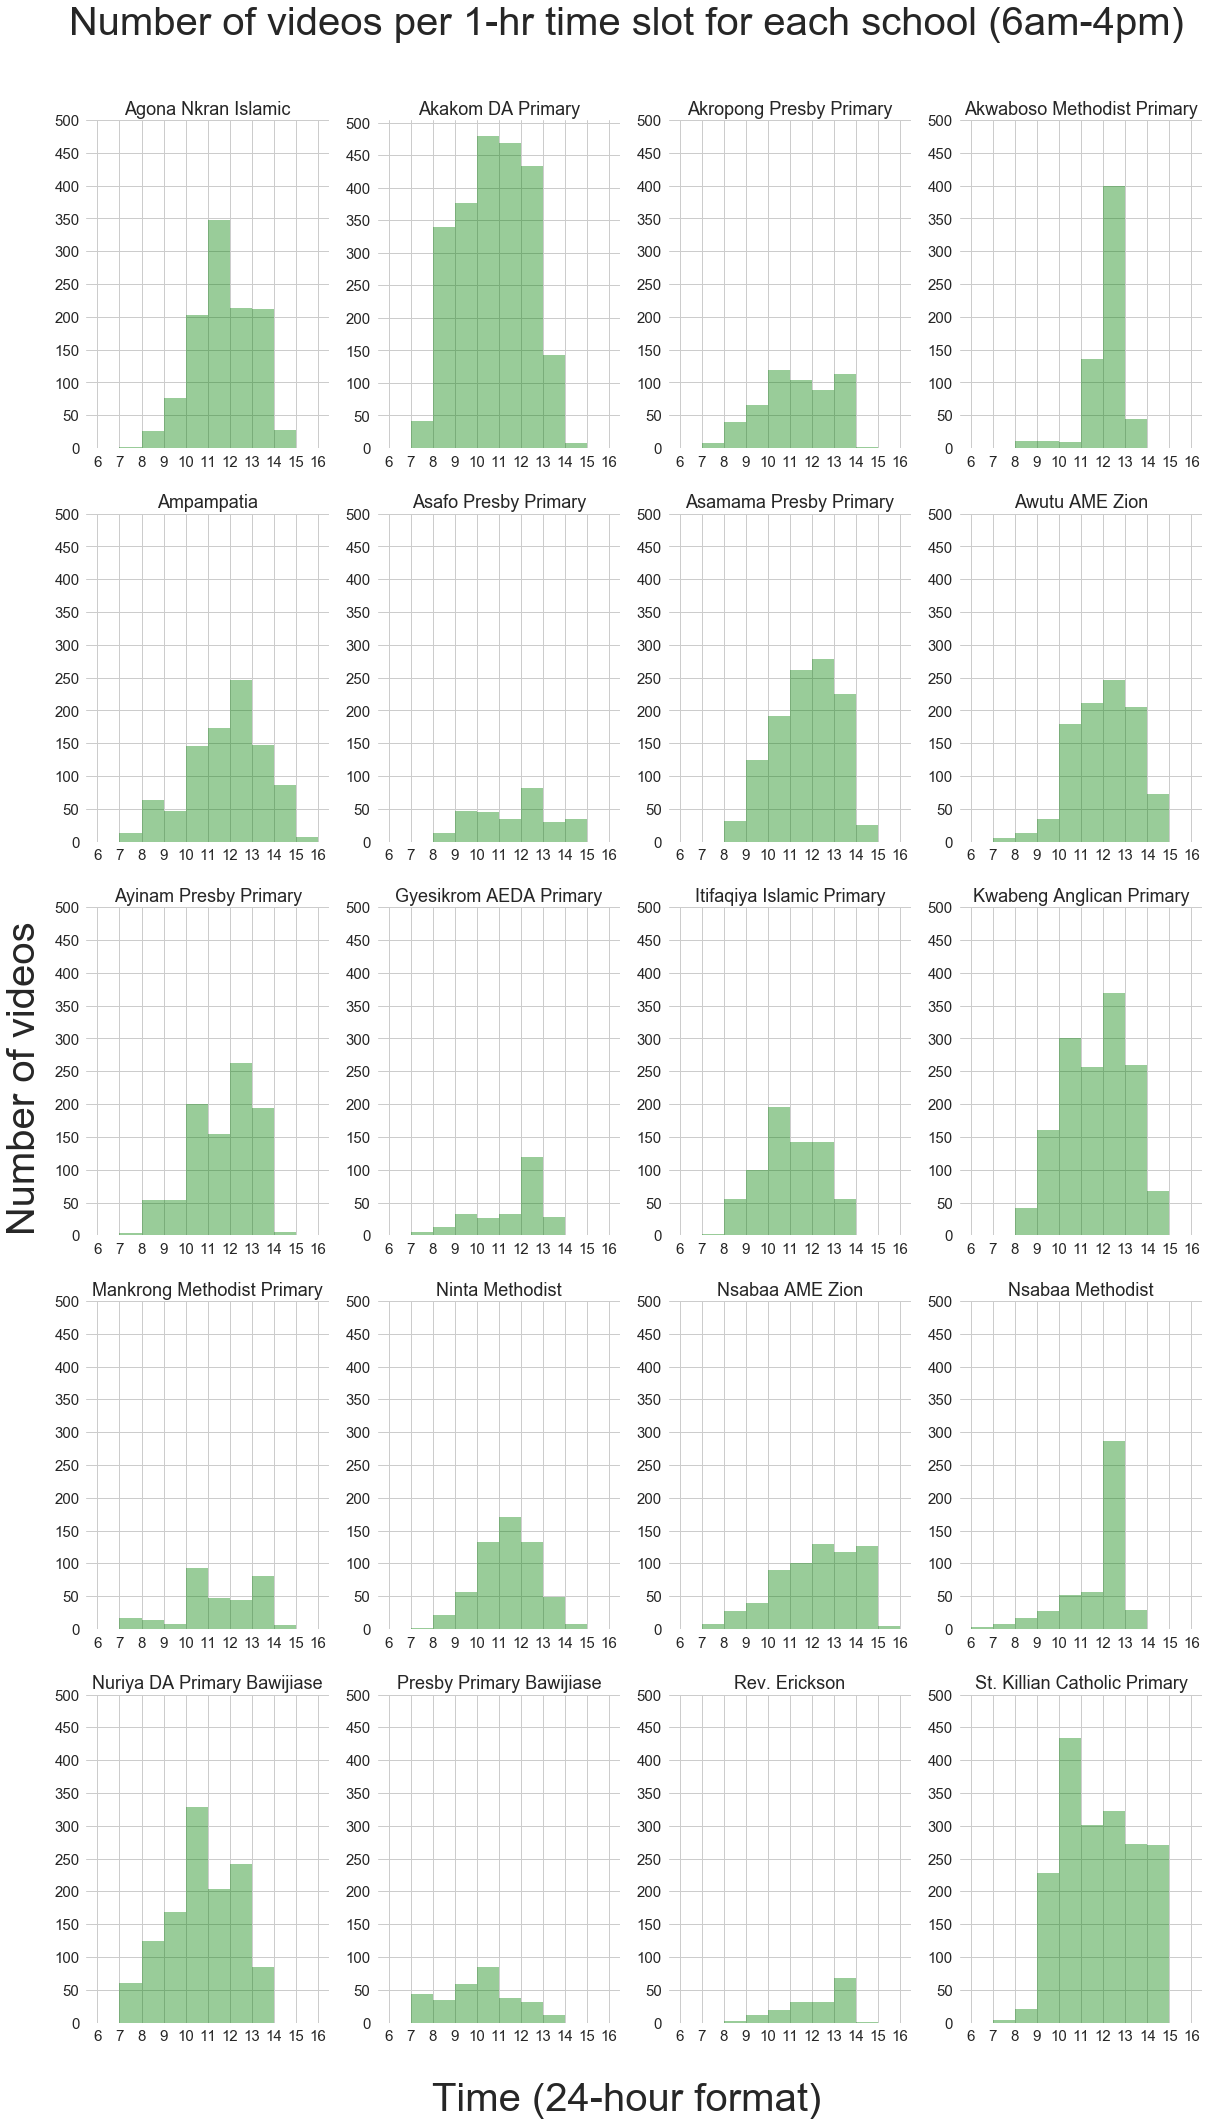

In [5]:
# add some space
print(2*'\n')

# list of list for times grouped by school, converted mins/secs to 0-100 scale
timesBySchool = [[ts[3].split(':') for ts in school] for school in sTimestamps]
timesBySchool = [sorted([float(t[0]+'.'+str(int(float(t[1])*100/60))+str(int(float(t[2])*100/60))) 
                         for t in school]) for school in timesBySchool]
# start and end times for each school, might be helpful later
startTimes = [t[0] for t in timesBySchool]
endTimes = [t[-1] for t in timesBySchool]

sns.set_style("whitegrid")

# create figure
fig = plt.figure(figsize=(20,35))

# histograms iterating over schools
for i, s in enumerate(schools):
    axis = fig.add_subplot(5,4,i+1)
    sns.distplot(timesBySchool[i], kde=False, color='g', ax=axis, bins=np.arange(6,17,1), rug=False);
    axis.set_title(s, FontSize=18)
    sns.despine(left=True,right=True,top=True,bottom=True, ax=axis)
    axis.tick_params(labelsize=15)
    axis.set_xticks(np.arange(6,17,1))
    axis.set_yticks(np.arange(0,550,50))

# main title and axis labels
fig.text(0.5, 0.09, 'Time (24-hour format)', ha='center', FontSize=40)
fig.text(0.07, 0.5, 'Number of videos', va='center', rotation='vertical', FontSize=40)
fig.suptitle('Number of videos per 1-hr time slot for each school (6am-4pm)', y=0.925,fontsize=40)
plt.savefig('timestamp_histograms')
plt.show()

In [6]:
# converting to pandas data frame (for convenience)
df = pd.concat([pd.DataFrame(d) for d in sTimestamps], keys=schools)
df.columns = ['Day', 'Month', 'Date', 'Time', 'Year']
df.head()

Day Month Date      Time  Year
Agona Nkran Islamic 0  Tue   Feb    7  10:06:30  2017
                    1  Tue   Feb    7  10:07:06  2017
                    2  Tue   Feb    7  10:07:40  2017
                    3  Tue   Feb    7  10:12:36  2017
                    4  Tue   Feb    7  10:13:24  2017

In [7]:
# add multi-print cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# data description for each school
for i,s in enumerate(schools):
    print(s)
    df.loc[schools[i]].describe()

Agona Nkran Islamic
Akakom DA Primary
Akropong Presby Primary
Akwaboso Methodist Primary
Ampampatia
Asafo Presby Primary
Asamama Presby Primary
Awutu AME Zion
Ayinam Presby Primary
Gyesikrom AEDA Primary
Itifaqiya Islamic Primary
Kwabeng Anglican Primary
Mankrong Methodist Primary
Ninta Methodist
Nsabaa AME Zion
Nsabaa Methodist
Nuriya DA Primary Bawijiase
Presby Primary Bawijiase
Rev. Erickson
St. Killian Catholic Primary


In [8]:
# time to float, e.g. 10:06:30 -> 10.1050
def timetofloat(s):
    t = s.split(':')
    return float(t[0]+'.'+str(int(float(t[1])*100/60))+str(int(float(t[2])*100/60)))
    
# Create dictionary of dataframes for each school's timestamps
header = ['Day', 'Month', 'Date', 'Time', 'Year']
dataframe_collection = {}
for i,s in enumerate(schools):
    dataframe_collection[s] = pd.DataFrame(sTimestamps[i], columns=header)
    dataframe_collection[s].name = s
    # add float time column
    dataframe_collection[s]['floatTime'] = dataframe_collection[s]['Time'].apply(timetofloat)

# example for first school
dataframe_collection[schools[0]].head()

,Day,Month,Date,Time,Year,floatTime
0,Tue,Feb,7,10:06:30,2017,10.1050
1,Tue,Feb,7,10:07:06,2017,10.1110
2,Tue,Feb,7,10:07:40,2017,10.1166
3,Tue,Feb,7,10:12:36,2017,10.2060
4,Tue,Feb,7,10:13:24,2017,10.2140


In [9]:
# double check unique month values (from aggregate df)
print(set(df["Month"]))
months = ['Jan','Feb','Mar']
    
# list of lists of tuples (min,max) for dates per month per school
dateRangesByMonthSchool = [[(dataframe_collection[s][dataframe_collection[s]['Month']==m]['Date'].astype(int).min(),
                             dataframe_collection[s][dataframe_collection[s]['Month']==m]['Date'].astype(int).max()) 
                            for m in months] for s in schools]

# convert to dataframe
df_dateRanges = pd.DataFrame(dateRangesByMonthSchool, columns=months, index=schools)
df_dateRanges

{'Jan', 'Feb', 'Mar'}


,Jan,Feb,Mar
Agona Nkran Islamic,"(nan, nan)","(7, 28)","(nan, nan)"
Akakom DA Primary,"(nan, nan)","(3, 27)","(nan, nan)"
Akropong Presby Primary,"(nan, nan)","(6, 20)","(nan, nan)"
Akwaboso Methodist Primary,"(nan, nan)","(3, 27)","(nan, nan)"
Ampampatia,"(nan, nan)","(7, 27)","(nan, nan)"
Asafo Presby Primary,"(nan, nan)","(15, 28)","(nan, nan)"
Asamama Presby Primary,"(nan, nan)","(6, 27)","(nan, nan)"
Awutu AME Zion,"(nan, nan)","(7, 28)","(1, 1)"
Ayinam Presby Primary,"(6, 20)","(20, 27)","(nan, nan)"
Gyesikrom AEDA Primary,"(nan, nan)","(8, 16)","(nan, nan)"


## 4: Reporting Observations:

### hard drive 1:
- Approx. 10am-1pm is the most active hand-washing period
- time slots 12-1pm and 10-11am are the two most active hour-long periods
- Dates for each month by school:
    - *January:* Only one school has any videos for this month (for hd1, anyway)  
    - *February:* All schools have videos for this month  
    - *March:* Five schools have videos for this month, but all of them are only for the first day of the month  
    **Conclusion:** Can probably just look at the month of February until there is more data for additional months




In [ ]:
# creating subplot matrices for hours per day (one for each school)
for s in schools:
    print(s)
    s_df_feb = dataframe_collection[s][dataframe_collection[s]['Month']=='Feb']
    # issues with Feb7 for Itifaqiya Islamic Primary.. (only a single video, excluding it from count)
    if s == schools[10]:
        s_df_feb = s_df_feb[s_df_feb['Date'] != '7']
    minmax = df_dateRanges['Feb'].loc[s]
    # create figure for subplot matrix (for particular school)
    fig = plt.figure(figsize=(20,35))
    for d in range(1,29): #(minmax[0],minmax[1]+1)
        s_df_feb_day = s_df_feb[s_df_feb['Date']==str(d)] # timestamps for particular school,month,date
        axis = fig.add_subplot(7,4,d);
        # change bin size
        sns.distplot(s_df_feb_day['floatTime'], kde=False, color='g', ax=axis, bins=np.arange(6,17,1), rug=False)
        axis.set_title('Feb '+str(d), FontSize=16);
        sns.despine(left=True,right=True,top=True,bottom=True, ax=axis);
        axis.tick_params(labelsize=10);
        axis.set_xticks(np.arange(6,17,1));
        axis.set_xlabel('')
        axis.set_yticks(np.arange(0,100,10))

    # main title and axis labels
    fig.text(0.5, 0.09, 'Time (24-hour format, 6am-4pm)', ha='center', FontSize=40)
    fig.text(0.07, 0.5, 'Number of videos', va='center', rotation='vertical', FontSize=40)
    fig.suptitle(s+':\nNumber of videos per 1-hr time slot per day', y=0.925,fontsize=38)
    plt.savefig('feb_times/'+s+'_feb_times.pdf',format='pdf')
    plt.show()